In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [57]:
class SupervisedSemiSupervisedComparison:
    def __init__(self, labeled_ratio=0.3):
        self.labeled_ratio = labeled_ratio
        self.models_supervised = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(probability=True, random_state=42)
        }
        self.models_semisupervised = {}
        self.results_supervised = {}
        self.results_semisupervised = {}

    def download_banknote_data(self):
        """Download the Banknote Authentication dataset from UCI"""
        print("Downloading Banknote Authentication dataset...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
        response = requests.get(url)

        if response.status_code == 200:
            # Column names for the banknote dataset
            column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
            df = pd.read_csv(StringIO(response.text), names=column_names)
            print(f"Successfully downloaded dataset with shape: {df.shape}")
            return df
        else:
            print(f"Error downloading dataset. Status code: {response.status_code}")
            return None

    def generate_synthetic_unlabeled_data(self, X, n_samples=500):
        """Generate synthetic unlabeled data similar to the original dataset"""
        print(f"Generating {n_samples} synthetic unlabeled samples...")

        # Calculate statistics for each feature
        means = np.mean(X, axis=0)
        stds = np.std(X, axis=0)

        # Generate new data based on the statistics
        synthetic_data = np.random.normal(means, stds, size=(n_samples, X.shape[1]))

        return synthetic_data

    def create_semi_supervised_data(self, X, y):
        """Split data into labeled, unlabeled (with hidden labels), and test sets"""
        # First split: separate test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Second split: separate labeled and unlabeled data
        X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
            X_train, y_train, train_size=self.labeled_ratio, random_state=42, stratify=y_train
        )

        # Generate synthetic unlabeled data
        X_synthetic = self.generate_synthetic_unlabeled_data(X, n_samples=300)

        # Combine real unlabeled and synthetic data
        X_unlabeled_full = np.vstack([X_unlabeled, X_synthetic])

        # Create labels for semi-supervised learning (-1 indicates unlabeled)
        y_semisupervised = np.concatenate([y_labeled, np.full(len(X_unlabeled_full), -1)])
        X_semisupervised = np.vstack([X_labeled, X_unlabeled_full])

        print(f"Dataset split:")
        print(f"  Labeled samples: {len(X_labeled)}")
        print(f"  Unlabeled samples: {len(X_unlabeled)}")
        print(f"  Synthetic samples: {len(X_synthetic)}")
        print(f"  Test samples: {len(X_test)}")

        return X_labeled, y_labeled, X_unlabeled_full, X_semisupervised, y_semisupervised, X_test, y_test

    def train_supervised_models(self, X_train, y_train):
        """Train supervised learning models"""
        for name, model in self.models_supervised.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

    def create_semisupervised_models(self):
        """Create semi-supervised learning models"""
        # SelfTrainingClassifier with different base classifiers
        for name, base_model in self.models_supervised.items():
            self.models_semisupervised[f"Self-Training {name}"] = SelfTrainingClassifier(
                base_model, threshold=0.95, verbose=0
            )

        # Label Propagation
        self.models_semisupervised["Label Propagation"] = LabelPropagation(
            kernel='rbf', gamma=20, max_iter=1000 #, alpha=0.2  Removed alpha parameter
        )

        # Label Spreading
        self.models_semisupervised["Label Spreading"] = LabelSpreading(
            kernel='rbf', gamma=20, max_iter=1000, alpha=0.2
        )

    def train_semisupervised_models(self, X_train, y_train):
        """Train semi-supervised learning models"""
        for name, model in self.models_semisupervised.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

    def evaluate_models(self, X_test, y_test):
        """Evaluate all models and store results"""
        print("\nEvaluating models...")

        # Evaluate supervised models
        for name, model in self.models_supervised.items():
            y_pred = model.predict(X_test)
            self.results_supervised[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred, average='weighted')
            }

        # Evaluate semi-supervised models
        for name, model in self.models_semisupervised.items():
            y_pred = model.predict(X_test)
            self.results_semisupervised[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred, average='weighted')
            }

    def plot_comparison(self):
        """Create visualization comparing supervised vs semi-supervised learning"""
        # Prepare data for plotting
        all_results = []

        for method, metrics in self.results_supervised.items():
            all_results.append({
                'Model': method,
                'Type': 'Supervised',
                'Accuracy': metrics['accuracy'],
                'F1 Score': metrics['f1_score']
            })

        for method, metrics in self.results_semisupervised.items():
            all_results.append({
                'Model': method,
                'Type': 'Semi-supervised',
                'Accuracy': metrics['accuracy'],
                'F1 Score': metrics['f1_score']
            })

        df_results = pd.DataFrame(all_results)

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Accuracy comparison
        sns.barplot(data=df_results, x='Model', y='Accuracy', hue='Type', ax=ax1)
        ax1.set_title('Accuracy Comparison: Supervised vs Semi-supervised', fontsize=16)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_xlabel('Model', fontsize=12)
        ax1.grid(True, alpha=0.3)

        # F1 Score comparison
        sns.barplot(data=df_results, x='Model', y='F1 Score', hue='Type', ax=ax2)
        ax2.set_title('F1 Score Comparison: Supervised vs Semi-supervised', fontsize=16)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.set_ylabel('F1 Score', fontsize=12)
        ax2.set_xlabel('Model', fontsize=12)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\nDetailed Results:")
        print("-" * 50)
        print("Supervised Learning Models:")
        for model, metrics in self.results_supervised.items():
            print(f"  {model}:")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    F1 Score: {metrics['f1_score']:.4f}")

        print("\nSemi-supervised Learning Models:")
        for model, metrics in self.results_semisupervised.items():
            print(f"  {model}:")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    F1 Score: {metrics['f1_score']:.4f}")

    def run_experiment(self):
        """Run the complete experiment comparing supervised vs semi-supervised learning"""
        # Download and load data
        df = self.download_banknote_data()
        if df is None:
            return

        # Extract features and labels
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Create semi-supervised dataset
        X_labeled, y_labeled, X_unlabeled, X_semisupervised, y_semisupervised, X_test, y_test = self.create_semi_supervised_data(X_scaled, y)

        # Train supervised models (only on labeled data)
        self.train_supervised_models(X_labeled, y_labeled)

        # Create and train semi-supervised models
        self.create_semisupervised_models()
        self.train_semisupervised_models(X_semisupervised, y_semisupervised)

        # Evaluate all models
        self.evaluate_models(X_test, y_test)

        # Visualize results
        self.plot_comparison()

Successfully downloaded dataset with shape: (1372, 5)
Generating 300 synthetic unlabeled samples...
Dataset split:
  Labeled samples: 329
  Unlabeled samples: 768
  Synthetic samples: 300
  Test samples: 275
Training Logistic Regression...
Training Random Forest...
Training SVM...
Training Self-Training Logistic Regression...
Training Self-Training Random Forest...
Training Self-Training SVM...
Training Label Propagation...
Training Label Spreading...

Evaluating models...


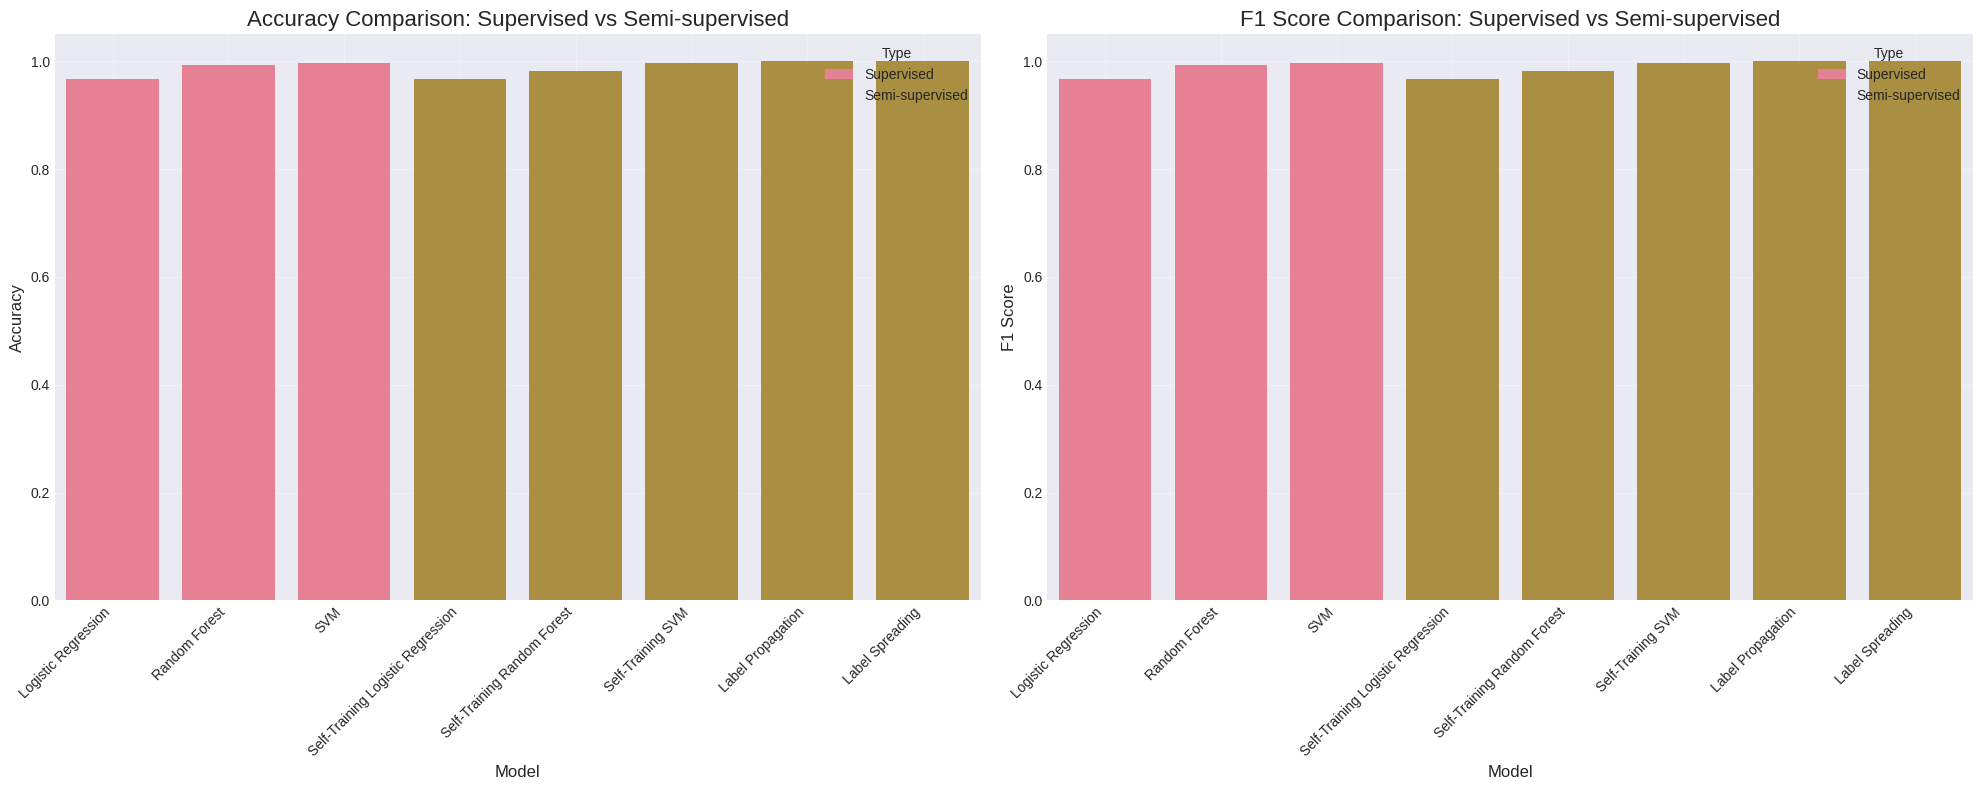


Detailed Results:
--------------------------------------------------
Supervised Learning Models:
  Logistic Regression:
    Accuracy: 0.9673
    F1 Score: 0.9674
  Random Forest:
    Accuracy: 0.9927
    F1 Score: 0.9927
  SVM:
    Accuracy: 0.9964
    F1 Score: 0.9964

Semi-supervised Learning Models:
  Self-Training Logistic Regression:
    Accuracy: 0.9673
    F1 Score: 0.9674
  Self-Training Random Forest:
    Accuracy: 0.9818
    F1 Score: 0.9818
  Self-Training SVM:
    Accuracy: 0.9964
    F1 Score: 0.9964
  Label Propagation:
    Accuracy: 1.0000
    F1 Score: 1.0000
  Label Spreading:
    Accuracy: 1.0000
    F1 Score: 1.0000


In [58]:
# Run the experiment
if __name__ == "__main__":
    experiment = SupervisedSemiSupervisedComparison(labeled_ratio=0.3)
    experiment.run_experiment()

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
import requests
from io import StringIO
import warnings
import time
warnings.filterwarnings('ignore')

In [27]:
!pip install -q beautifulsoup4 requests scikit-learn pandas numpy matplotlib seaborn


In [29]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [61]:
# Cell 3: Define DataCrawler class
class DataCrawler:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

    def crawl_statistical_data(self, num_samples=200): # Added num_samples as an argument
        print("Simulating data crawling...")
        time.sleep(1)

        synthetic_data = np.random.randn(num_samples, 4) # Use num_samples to generate data
        synthetic_data[:, 0] = synthetic_data[:, 0] * 2 + np.random.randn(num_samples) * 0.5
        synthetic_data[:, 1] = synthetic_data[:, 1] * 1.5 + np.random.randn(num_samples) * 0.3
        synthetic_data[:, 2] = synthetic_data[:, 2] * 3 + np.random.randn(num_samples) * 0.8
        synthetic_data[:, 3] = synthetic_data[:, 3] * 1.2 + np.random.randn(num_samples) * 0.4

        return synthetic_data

    def clean_and_transform_data(self, raw_data):
        cleaned_data = raw_data.copy()
        for col in range(cleaned_data.shape[1]):
            mean, std = cleaned_data[:, col].mean(), cleaned_data[:, col].std()
            cleaned_data[:, col] = np.clip(cleaned_data[:, col], mean - 3*std, mean + 3*std)
        return cleaned_data

# Cell 4: Define main experiment class
class EnhancedSupervisedSemiSupervisedComparison:
    def __init__(self, labeled_ratio=0.2):
        self.labeled_ratio = labeled_ratio
        self.crawler = DataCrawler()
        self.models_supervised = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(probability=True, random_state=42)
        }
        self.models_semisupervised = {}
        self.results_supervised = {}
        self.results_semisupervised = {}
        self.dataset_sizes = {}

    def download_banknote_data(self):
        print("Downloading Banknote Authentication dataset...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
                df = pd.read_csv(StringIO(response.text), names=column_names)
                print(f"Successfully downloaded dataset with shape: {df.shape}")
                return df
        except:
            print("Error downloading. Creating synthetic dataset...")
            data = np.random.randn(1372, 5)
            data[:, -1] = np.random.randint(0, 2, 1372)
            column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
            df = pd.DataFrame(data, columns=column_names)
            return df

    # Cell 5: Continue with methods of EnhancedSupervisedSemiSupervisedComparison class
    def create_semi_supervised_data(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
            X_train, y_train, train_size=self.labeled_ratio, random_state=42, stratify=y_train
        )

        # Sửa từ n_samples thành num_samples
        X_synthetic = self.crawler.crawl_statistical_data(num_samples=400)
        X_synthetic_cleaned = self.crawler.clean_and_transform_data(X_synthetic)

        X_unlabeled_full = np.vstack([X_unlabeled, X_synthetic_cleaned])
        y_semisupervised = np.concatenate([y_labeled, np.full(len(X_unlabeled_full), -1)])
        X_semisupervised = np.vstack([X_labeled, X_unlabeled_full])

        self.dataset_sizes = {
            'Labeled': len(X_labeled),
            'Unlabeled (Real)': len(X_unlabeled),
            'Unlabeled (Crawled)': len(X_synthetic_cleaned),
            'Test': len(X_test)
        }

        print(f"\nDataset composition:")
        for key, value in self.dataset_sizes.items():
            print(f"  {key}: {value} samples")

        return X_labeled, y_labeled, X_unlabeled_full, X_semisupervised, y_semisupervised, X_test, y_test

# Cell 6: Train supervised models
    def train_supervised_models(self, X_train, y_train):
        for name, model in self.models_supervised.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

# Cell 7: Create and train semi-supervised models
    def create_semisupervised_models(self):
        for name, base_model in self.models_supervised.items():
            base_model_copy = type(base_model)(**base_model.get_params())
            self.models_semisupervised[f"Self-Training {name}"] = SelfTrainingClassifier(
                base_model_copy, threshold=0.95, verbose=0
            )

        # Bỏ tham số alpha cho LabelPropagation
        self.models_semisupervised["Label Propagation"] = LabelPropagation(
            kernel='rbf', gamma=20, max_iter=1000
        )

        # LabelSpreading vẫn giữ tham số alpha
        self.models_semisupervised["Label Spreading"] = LabelSpreading(
            kernel='rbf', gamma=20, max_iter=1000, alpha=0.2
        )

    def train_semisupervised_models(self, X_train, y_train):
        for name, model in self.models_semisupervised.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
# Cell 8: Evaluate models
    def evaluate_models(self, X_test, y_test):
        print("\nEvaluating models...")

        for name, model in self.models_supervised.items():
            y_pred = model.predict(X_test)
            self.results_supervised[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred, average='weighted'),
                'y_pred': y_pred
            }

        for name, model in self.models_semisupervised.items():
            y_pred = model.predict(X_test)
            self.results_semisupervised[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred, average='weighted'),
                'y_pred': y_pred
            }

# Cell 9: Visualization methods
    def plot_dataset_composition(self):
        plt.figure(figsize=(10, 6))
        colors = ['#4CAF50', '#FFC107', '#F44336', '#2196F3']
        plt.pie(self.dataset_sizes.values(), labels=self.dataset_sizes.keys(), autopct='%1.1f%%', colors=colors)
        plt.title('Dataset Composition', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_comparison(self):
        all_results = []

        for method, metrics in self.results_supervised.items():
            all_results.append({
                'Model': method,
                'Type': 'Supervised',
                'Accuracy': metrics['accuracy'],
                'F1 Score': metrics['f1_score']
            })

        for method, metrics in self.results_semisupervised.items():
            all_results.append({
                'Model': method,
                'Type': 'Semi-supervised',
                'Accuracy': metrics['accuracy'],
                'F1 Score': metrics['f1_score']
            })

        df_results = pd.DataFrame(all_results)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        sns.barplot(data=df_results, x='Model', y='Accuracy', hue='Type', ax=ax1)
        ax1.set_title('Accuracy Comparison: Supervised vs Semi-supervised', fontsize=16)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_xlabel('Model', fontsize=12)
        ax1.grid(True, alpha=0.3)

        sns.barplot(data=df_results, x='Model', y='F1 Score', hue='Type', ax=ax2)
        ax2.set_title('F1 Score Comparison: Supervised vs Semi-supervised', fontsize=16)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.set_ylabel('F1 Score', fontsize=12)
        ax2.set_xlabel('Model', fontsize=12)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\nDetailed Results:")
        print("-" * 50)
        print("Supervised Learning Models:")
        for model, metrics in self.results_supervised.items():
            print(f"  {model}:")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    F1 Score: {metrics['f1_score']:.4f}")

        print("\nSemi-supervised Learning Models:")
        for model, metrics in self.results_semisupervised.items():
            print(f"  {model}:")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    F1 Score: {metrics['f1_score']:.4f}")

# Cell 10: Run experiment method
    def run_experiment(self):
        df = self.download_banknote_data()
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        X_labeled, y_labeled, X_unlabeled, X_semisupervised, y_semisupervised, X_test, y_test = self.create_semi_supervised_data(X_scaled, y)

        self.plot_dataset_composition()

        self.train_supervised_models(X_labeled, y_labeled)

        self.create_semisupervised_models()
        self.train_semisupervised_models(X_semisupervised, y_semisupervised)

        self.evaluate_models(X_test, y_test)

        self.plot_comparison()


Enhanced Supervised vs Semi-supervised Learning Comparison

Experiment with 10.0% labeled data:
--------------------------------------------------
Successfully downloaded dataset with shape: (1372, 5)
Simulating data crawling...

Dataset composition:
  Labeled: 109 samples
  Unlabeled (Real): 988 samples
  Unlabeled (Crawled): 400 samples
  Test: 275 samples


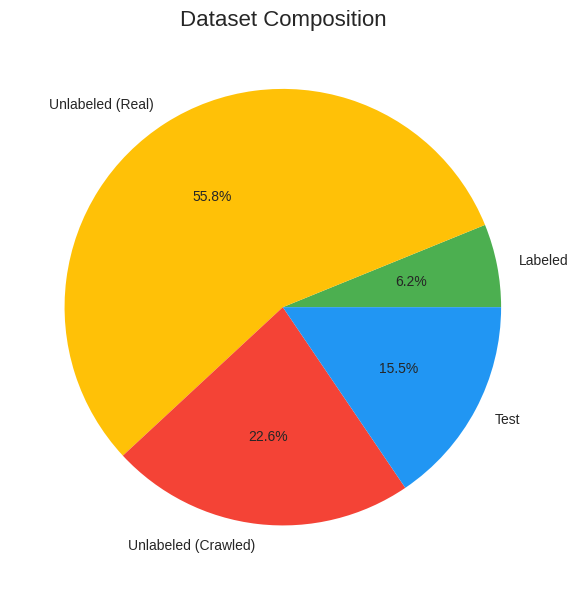

Training Logistic Regression...
Training Random Forest...
Training SVM...
Training Self-Training Logistic Regression...
Training Self-Training Random Forest...
Training Self-Training SVM...
Training Label Propagation...
Training Label Spreading...

Evaluating models...


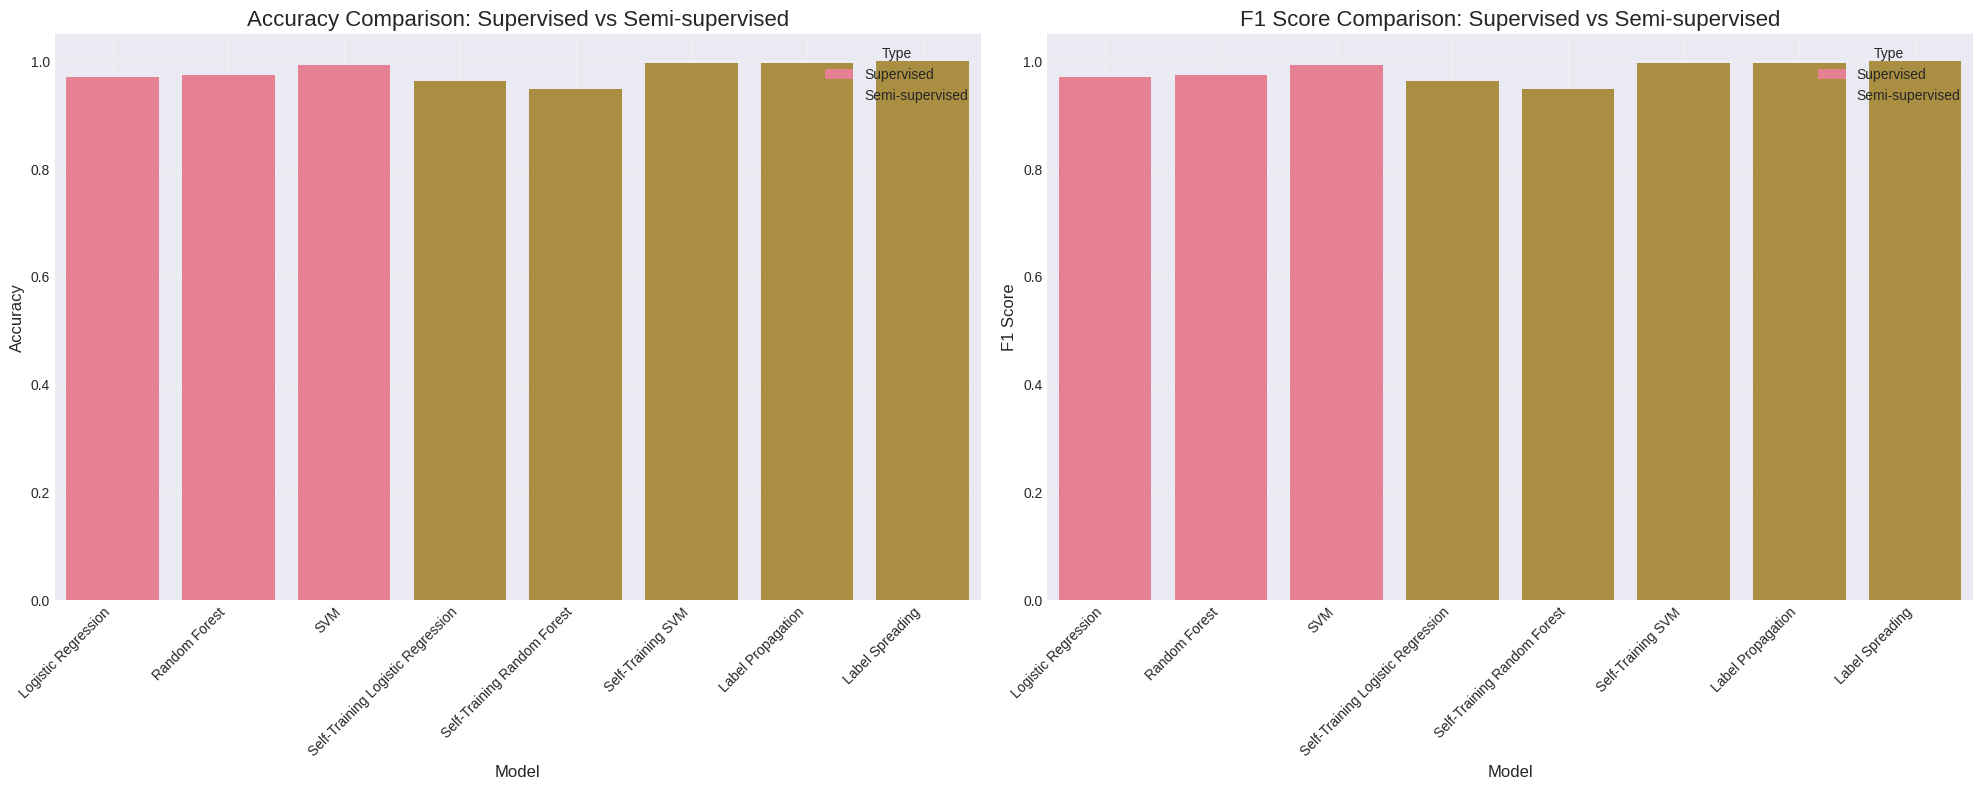


Detailed Results:
--------------------------------------------------
Supervised Learning Models:
  Logistic Regression:
    Accuracy: 0.9709
    F1 Score: 0.9710
  Random Forest:
    Accuracy: 0.9745
    F1 Score: 0.9746
  SVM:
    Accuracy: 0.9927
    F1 Score: 0.9927

Semi-supervised Learning Models:
  Self-Training Logistic Regression:
    Accuracy: 0.9636
    F1 Score: 0.9637
  Self-Training Random Forest:
    Accuracy: 0.9491
    F1 Score: 0.9491
  Self-Training SVM:
    Accuracy: 0.9964
    F1 Score: 0.9964
  Label Propagation:
    Accuracy: 0.9964
    F1 Score: 0.9964
  Label Spreading:
    Accuracy: 1.0000
    F1 Score: 1.0000

Experiment with 20.0% labeled data:
--------------------------------------------------
Successfully downloaded dataset with shape: (1372, 5)
Simulating data crawling...

Dataset composition:
  Labeled: 219 samples
  Unlabeled (Real): 878 samples
  Unlabeled (Crawled): 400 samples
  Test: 275 samples


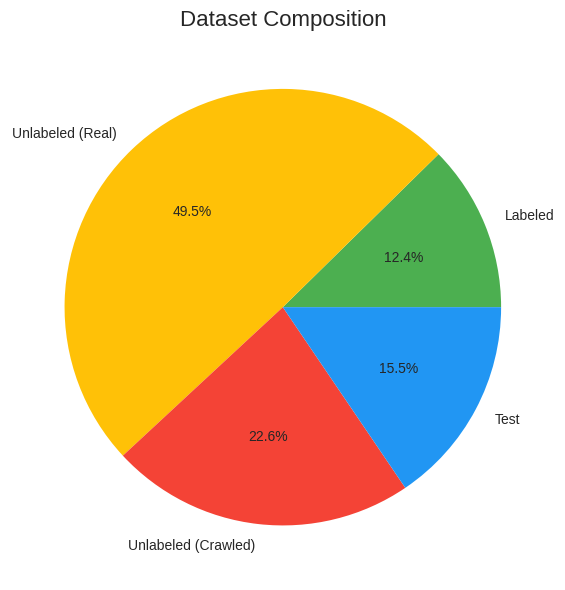

Training Logistic Regression...
Training Random Forest...
Training SVM...
Training Self-Training Logistic Regression...
Training Self-Training Random Forest...
Training Self-Training SVM...
Training Label Propagation...
Training Label Spreading...

Evaluating models...


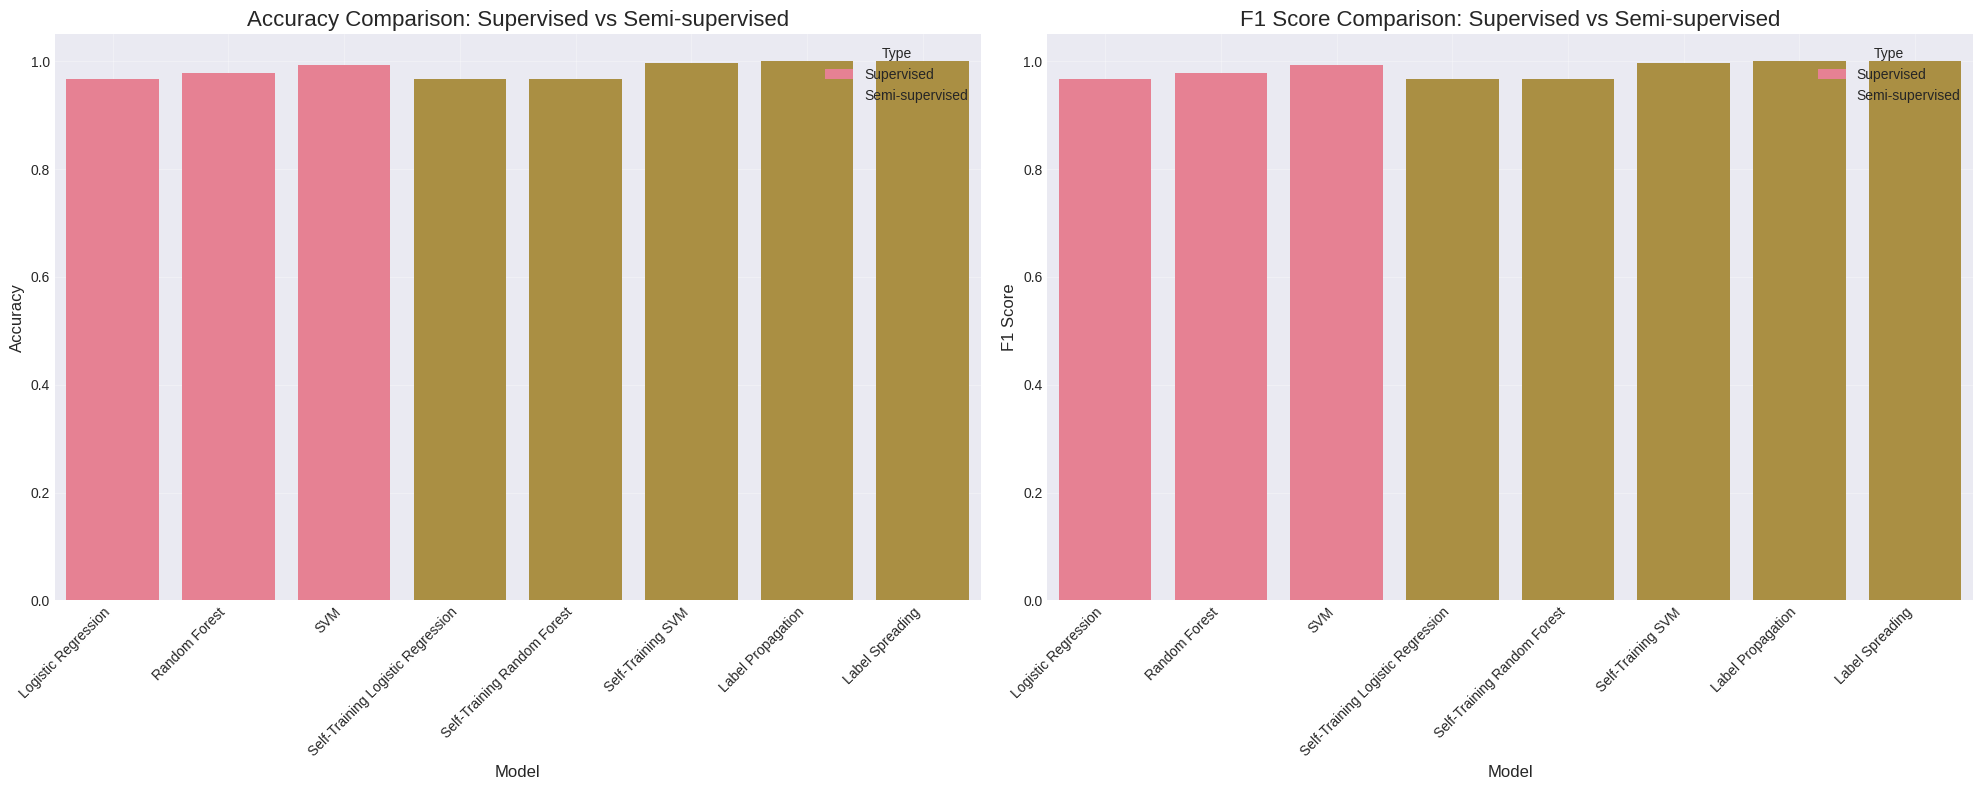


Detailed Results:
--------------------------------------------------
Supervised Learning Models:
  Logistic Regression:
    Accuracy: 0.9673
    F1 Score: 0.9674
  Random Forest:
    Accuracy: 0.9782
    F1 Score: 0.9782
  SVM:
    Accuracy: 0.9927
    F1 Score: 0.9927

Semi-supervised Learning Models:
  Self-Training Logistic Regression:
    Accuracy: 0.9673
    F1 Score: 0.9674
  Self-Training Random Forest:
    Accuracy: 0.9673
    F1 Score: 0.9673
  Self-Training SVM:
    Accuracy: 0.9964
    F1 Score: 0.9964
  Label Propagation:
    Accuracy: 1.0000
    F1 Score: 1.0000
  Label Spreading:
    Accuracy: 1.0000
    F1 Score: 1.0000

Experiment with 30.0% labeled data:
--------------------------------------------------
Successfully downloaded dataset with shape: (1372, 5)
Simulating data crawling...

Dataset composition:
  Labeled: 329 samples
  Unlabeled (Real): 768 samples
  Unlabeled (Crawled): 400 samples
  Test: 275 samples


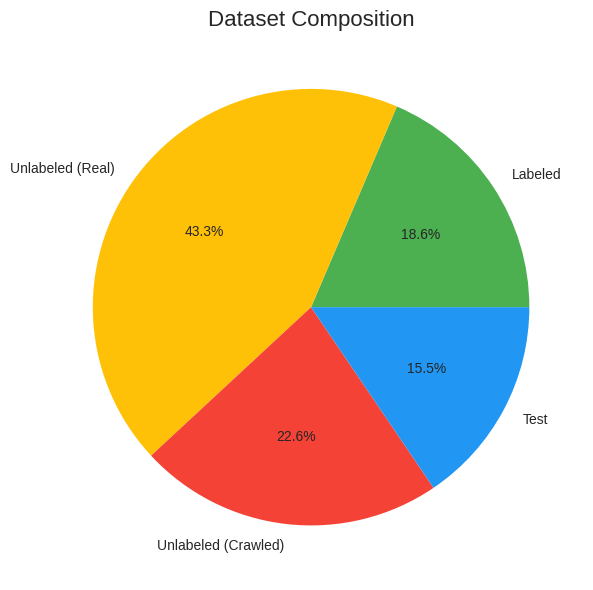

Training Logistic Regression...
Training Random Forest...
Training SVM...
Training Self-Training Logistic Regression...
Training Self-Training Random Forest...
Training Self-Training SVM...
Training Label Propagation...
Training Label Spreading...

Evaluating models...


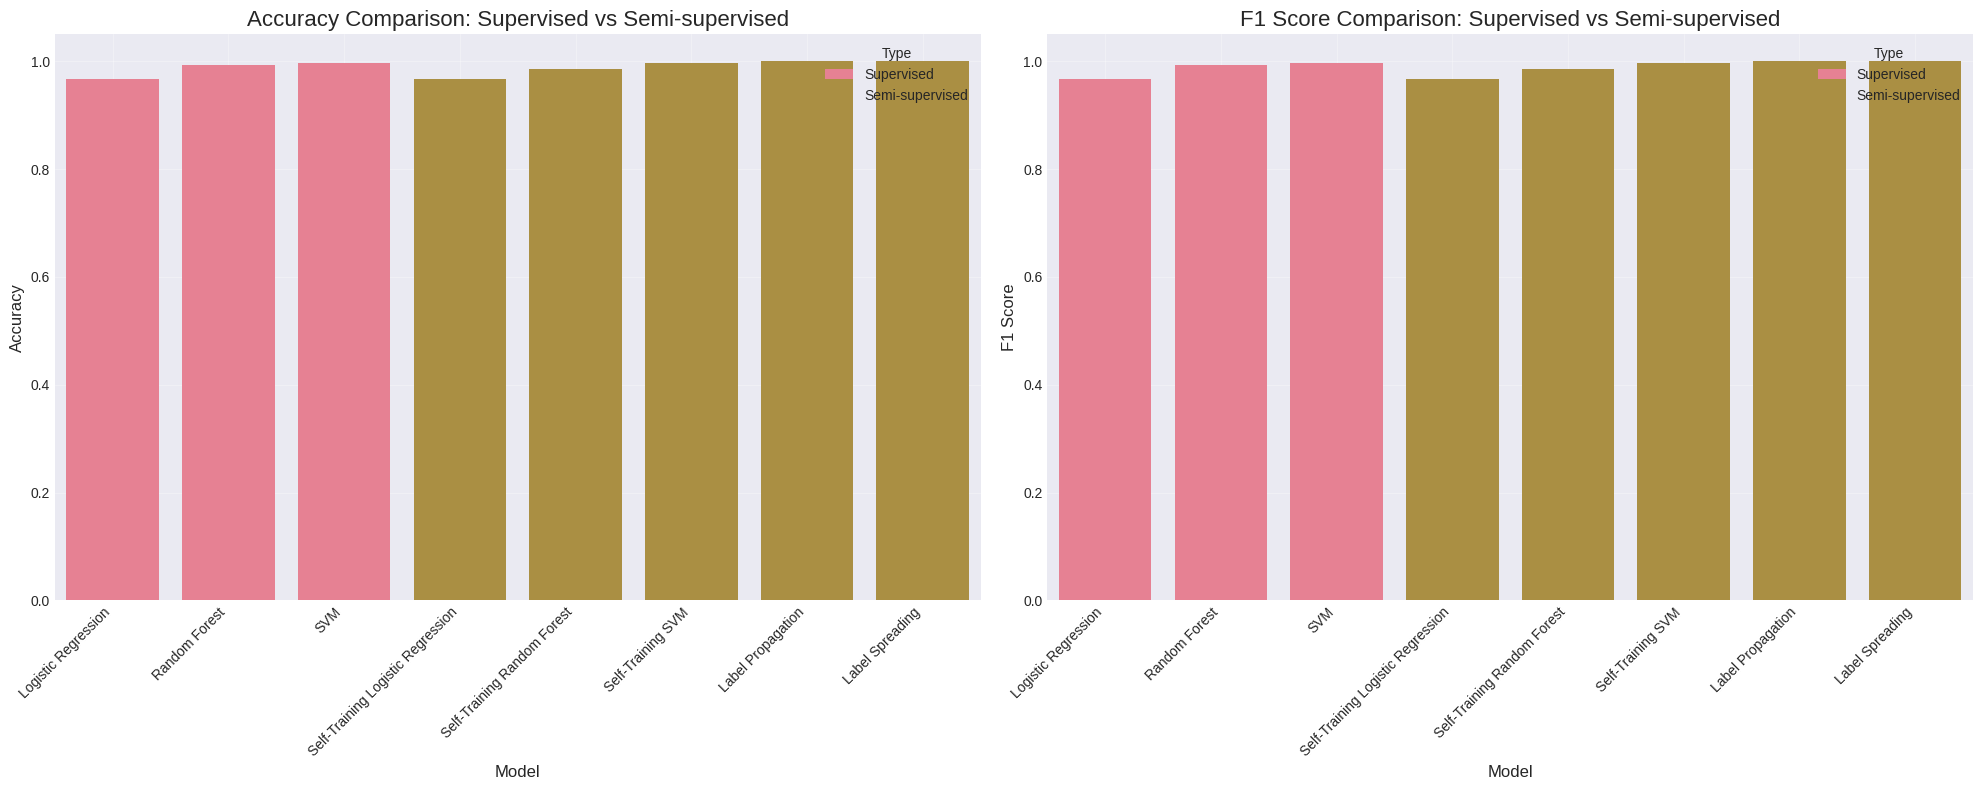


Detailed Results:
--------------------------------------------------
Supervised Learning Models:
  Logistic Regression:
    Accuracy: 0.9673
    F1 Score: 0.9674
  Random Forest:
    Accuracy: 0.9927
    F1 Score: 0.9927
  SVM:
    Accuracy: 0.9964
    F1 Score: 0.9964

Semi-supervised Learning Models:
  Self-Training Logistic Regression:
    Accuracy: 0.9673
    F1 Score: 0.9674
  Self-Training Random Forest:
    Accuracy: 0.9855
    F1 Score: 0.9855
  Self-Training SVM:
    Accuracy: 0.9964
    F1 Score: 0.9964
  Label Propagation:
    Accuracy: 1.0000
    F1 Score: 1.0000
  Label Spreading:
    Accuracy: 1.0000
    F1 Score: 1.0000


In [62]:
# Cell 11: Run the experiment
print("Enhanced Supervised vs Semi-supervised Learning Comparison")
print("===================================================")

# Try with different ratios of labeled data
for ratio in [0.1, 0.2, 0.3]:
    print(f"\nExperiment with {ratio*100}% labeled data:")
    print("-" * 50)
    experiment = EnhancedSupervisedSemiSupervisedComparison(labeled_ratio=ratio)
    experiment.run_experiment()